In [1]:
!pip install transformers timm matplotlib seaborn grpcio kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

*   **transformers:** para modelos ViT e Inception-ResNet.
*   **timm:** una librería fácil para cargar Inception-ResNet.
*   **kaggle:** para descargar NutritionVerse‑Real directamente desde Kaggle

In [2]:
# Configura la API de Kaggle
from google.colab import files
files.upload()  # aquí cargas tu kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descarga y descomprime el dataset
!kaggle datasets download -d nutritionverse/nutritionverse-real
!unzip nutritionverse-real.zip -d data/

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nutritionverse/nutritionverse-real
License(s): CC-BY-NC-SA-4.0
100% 1.03G/1.03G [00:09<00:00, 97.9MB/s]
100% 1.03G/1.03G [00:09<00:00, 120MB/s] 
Archive:  nutritionverse-real.zip
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/_annotations.coco.json  
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/dish_100_IMG_8463_jpeg.rf.12dff1eff06891929b113d0008f31c25.jpg  
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/dish_100_IMG_8464_jpeg.rf.1f908f42dfc47bff5416f085aa129db2.jpg  
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/dish_100_IMG_8476_jpeg.rf.781889f8adc708e5f3b1f166d5efecd8.jpg  
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/dish_100_IMG_8484_jpeg.rf.30f33b8a695429ce2cf377655067db5d.jpg  
  inflating: data/nutritionverse-manual/nutritionverse-manual/images/dish_101_IMG_8502_jpeg.rf.fca3d8ea24fd1fc01

In [3]:
import os
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 1. Cargar los datasets
df_meta = pd.read_csv('data/nutritionverse_dish_metadata3.csv')
df_splits = pd.read_csv('data/nutritionverse-manual/nutritionverse-manual/updated-manual-dataset-splits.csv')

# 2. Extraer dish_id del nombre de archivo en df_splits
def extract_dish_id(filename):
    match = re.search(r'dish_(\d+)_', filename)
    return match.group(1) if match else None

df_splits['dish_id'] = df_splits['file_name'].apply(extract_dish_id)

# 3. Convertir dish_id a string en ambos dataframes
df_meta['dish_id'] = df_meta['dish_id'].astype(str)
df_splits['dish_id'] = df_splits['dish_id'].astype(str)

# 4. Corregir nombres de categoría (Train->train, Val->val)
df_splits['category'] = df_splits['category'].str.lower()

# 5. Unir los dataframes
df = pd.merge(df_splits, df_meta, on='dish_id', how='inner')

# 6. Verificar si hay datos
if df.empty:
    print("⚠️ No hay coincidencias entre los IDs de los datasets")
    print("IDs en metadata:", df_meta['dish_id'].unique()[:10])
    print("IDs en splits:", df_splits['dish_id'].dropna().unique()[:10])
else:
    # 7. Construir rutas de imágenes
    df['image_path'] = df['file_name'].apply(
        lambda f: os.path.join('data/nutritionverse-manual/nutritionverse-manual/images', f)
    )

    # 8. Filtrar solo imágenes que existen
    df = df[df['image_path'].apply(os.path.exists)]

    # 9. Dividir en train/val
    train_df = df[df['category'] == 'train']
    val_df = df[df['category'] == 'val']

    print(f"📊 Datos finales:")
    print(f"- Train: {len(train_df)} imágenes")
    print(f"- Val: {len(val_df)} imágenes")

    # 10. Definir transformaciones
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # 11. Clase Dataset
    class FoodDataset(Dataset):
        def __init__(self, df, transform):
            self.df = df.reset_index(drop=True)
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = Image.open(row['image_path']).convert('RGB')
            x = self.transform(img)
            y_cols = ['total_calories', 'total_food_weight', 'total_protein',
                     'total_fats', 'total_carbohydrates']
            y_values = [float(row[col]) for col in y_cols]  # Conversión explícita
            y = torch.tensor(y_values, dtype=torch.float32)
            return x, y

    # 12. Crear DataLoaders
    if len(train_df) > 0:
        train_dl = DataLoader(FoodDataset(train_df, transform), batch_size=16, shuffle=True)
        print(f"✅ Dataloader de entrenamiento creado con {len(train_dl.dataset)} muestras")

    if len(val_df) > 0:
        val_dl = DataLoader(FoodDataset(val_df, transform), batch_size=16)
        print(f"✅ Dataloader de validación creado con {len(val_dl.dataset)} muestras")

📊 Datos finales:
- Train: 624 imágenes
- Val: 265 imágenes
✅ Dataloader de entrenamiento creado con 624 muestras
✅ Dataloader de validación creado con 265 muestras


#ResNet50

In [4]:
import timm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = timm.create_model('resnet50', pretrained=True, num_classes=0)
        self.features = backbone
        self.head = nn.Linear(backbone.num_features, 5)  # 5 salidas nutricionales
    def forward(self, x):
        return self.head(self.features(x))

cnn = CNNRegressor().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

#Modelo ViT (Vision Transformer)

In [5]:
from transformers import ViTModel

class ViTRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        hidden = self.vit.config.hidden_size
        self.head = nn.Sequential(
            nn.Linear(hidden, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )
    def forward(self, x):
        out = self.vit(x).pooler_output
        return self.head(out)
vit = ViTRegressor().to(device)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

#Entrenamiento y evaluaciones

In [10]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm.auto import tqdm

# Función de entrenamiento por época
def train_epoch(model, dl, opt, loss_fn, epoch, total_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dl, desc=f'Época {epoch+1}/{total_epochs}', leave=False)

    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(dl)

# Función de evaluación
def eval_model(model, dl, loss_fn):
    model.eval()
    losses, preds_list, ys = [], [], []

    with torch.no_grad():
        progress_bar = tqdm(dl, desc='Evaluando', leave=False)
        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            p = model(x)
            losses.append(loss_fn(p,y).item())
            preds_list.append(p.cpu().numpy())
            ys.append(y.cpu().numpy())

    preds, ys = np.vstack(preds_list), np.vstack(ys)
    mae = mean_absolute_error(ys, preds)
    return np.mean(losses), mae

In [11]:
# 1. Verificar y limpiar las columnas nutricionales
nutritional_cols = [
    'total_calories',
    'total_food_weight',
    'total_protein',
    'total_fats',
    'total_carbohydrates'
]

# Convertir a numérico y reemplazar valores no válidos
for col in nutritional_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convierte strings/inválidos a NaN

# Eliminar filas con valores NaN en las columnas nutricionales
df = df.dropna(subset=nutritional_cols).copy()

# 2. Actualizar los DataFrames de train/val
train_df = df[df['category'] == 'train']
val_df = df[df['category'] == 'val']

print(f"📊 Dataset limpio: Train={len(train_df)} | Val={len(val_df)}")

📊 Dataset limpio: Train=624 | Val=265


In [12]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# DataLoaders actualizados
train_dl = DataLoader(FoodDataset(train_df, transform), batch_size=16, shuffle=True)
val_dl   = DataLoader(FoodDataset(val_df, transform), batch_size=16)


In [13]:
loss_fn = nn.MSELoss()
opt_cnn = optim.Adam(cnn.parameters(), lr=1e-4)
opt_vit = optim.Adam(vit.parameters(), lr=3e-5)

results = {'cnn': [], 'vit': []}
total_epochs = 3  # Puedes ajustar esto

for model, opt, name in [(cnn, opt_cnn, 'cnn'), (vit, opt_vit, 'vit')]:
    print(f"\n🚀 Comenzando entrenamiento para {name.upper()}")

    for epoch in range(total_epochs):
        # Entrenamiento con barra de progreso
        train_loss = train_epoch(model, train_dl, opt, loss_fn, epoch, total_epochs)

        # Evaluación
        val_loss, mae = eval_model(model, val_dl, loss_fn)

        # Guardar resultados
        results[name].append((train_loss, val_loss, mae))

        # Mostrar resumen de la época
        print(f"\n{name.upper()} | Época {epoch+1}/{total_epochs}")
        print(f"► Pérdida entrenamiento: {train_loss:.4f}")
        print(f"► Pérdida validación:   {val_loss:.4f}")
        print(f"► MAE:                  {mae:.2f}")

        # Tiempo estimado (opcional)
        if epoch == 0:
            import time
            start_time = time.time()
        elif epoch == 1:
            elapsed = time.time() - start_time
            remaining = elapsed * (total_epochs - 2)
            print(f"\n⏱ Tiempo estimado restante: {remaining/60:.1f} minutos")


🚀 Comenzando entrenamiento para CNN


Época 1/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


CNN | Época 1/3
► Pérdida entrenamiento: 361867.8385
► Pérdida validación:   367936.4065
► MAE:                  288.31


Época 2/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


CNN | Época 2/3
► Pérdida entrenamiento: 360717.4010
► Pérdida validación:   366180.4011
► MAE:                  286.12

⏱ Tiempo estimado restante: 9.1 minutos


Época 3/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


CNN | Época 3/3
► Pérdida entrenamiento: 358378.9603
► Pérdida validación:   363932.8701
► MAE:                  284.30

🚀 Comenzando entrenamiento para VIT


Época 1/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


VIT | Época 1/3
► Pérdida entrenamiento: 361991.5837
► Pérdida validación:   367602.1561
► MAE:                  288.80


Época 2/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


VIT | Época 2/3
► Pérdida entrenamiento: 360258.5847
► Pérdida validación:   365529.4455
► MAE:                  287.00

⏱ Tiempo estimado restante: 21.9 minutos


Época 3/3:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/17 [00:00<?, ?it/s]


VIT | Época 3/3
► Pérdida entrenamiento: 357624.7290
► Pérdida validación:   362319.9528
► MAE:                  283.83


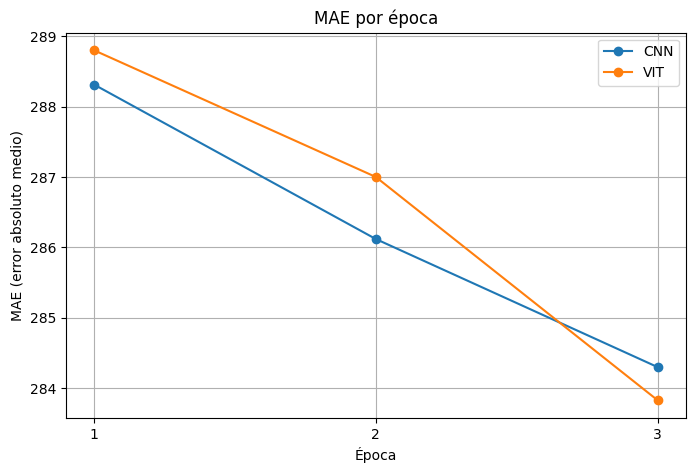

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for name in results:
    maes = [r[2] for r in results[name]]
    epochs = list(range(1, len(maes)+1))  # Fuerza eje X: [1, 2, 3]
    plt.plot(epochs, maes, marker='o', label=name.upper())

plt.title("MAE por época")
plt.xlabel("Época")
plt.ylabel("MAE (error absoluto medio)")
plt.xticks(epochs)  # Asegura que salgan los ticks de cada época
plt.legend()
plt.grid(True)
plt.show()


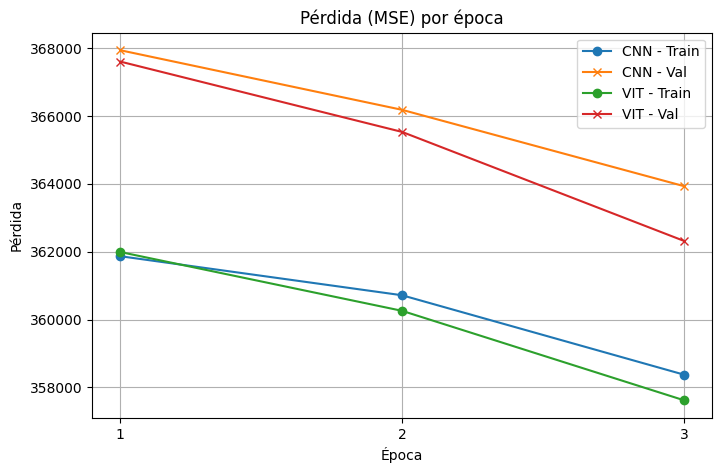

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for name in results:
    train_losses = [r[0] for r in results[name]]
    val_losses = [r[1] for r in results[name]]
    epochs = list(range(1, len(train_losses)+1))

    plt.plot(epochs, train_losses, marker='o', label=f'{name.upper()} - Train')
    plt.plot(epochs, val_losses, marker='x', label=f'{name.upper()} - Val')

plt.title("Pérdida (MSE) por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()
